<a href="https://colab.research.google.com/github/hlapin/DHTeaching/blob/master/Getting_Started_With_Text_Mining.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Getting the text
We are going to be working with the Federalist Papers  
We need to:
1. Download a zip file from github (Programming Historian repository)
2. Unzip it and
3. Unpack the files in a local folder [local to Colab]

After this you ***can*** skip to the Stylometry demo instead of the the LDA topic modelling.



In [1]:
import requests, io, zipfile, os
os.chdir ('/content/') # changes working directory on local machine
r = requests.get('https://github.com/programminghistorian/ph-submissions/blob/gh-pages/assets/introduction-to-stylometry-with-python/stylometry-federalist.zip?raw=true')
z = zipfile.ZipFile(io.BytesIO(r.content))
z.extractall() 



There is now a local file on the virtual machine you are using called `data` with the files   
You can check that in the files tools in the left hand panel.   
However, let's set the working directory to that directory confirm it and list its contents programmatically.
 

In [2]:
os.chdir ('/content/data') # changes working directory on local machine
print ('current working directory:')
print (os.getcwd()) # prints path to current working directory 
print ('file list:')
%ls #instruction to list file directory

# did you not get a file list? a directory? if not we have a problem.

current working directory:
/content/data
file list:
federalist_10.txt  federalist_30.txt  federalist_50.txt  federalist_70.txt
federalist_11.txt  federalist_31.txt  federalist_51.txt  federalist_71.txt
federalist_12.txt  federalist_32.txt  federalist_52.txt  federalist_72.txt
federalist_13.txt  federalist_33.txt  federalist_53.txt  federalist_73.txt
federalist_14.txt  federalist_34.txt  federalist_54.txt  federalist_74.txt
federalist_15.txt  federalist_35.txt  federalist_55.txt  federalist_75.txt
federalist_16.txt  federalist_36.txt  federalist_56.txt  federalist_76.txt
federalist_17.txt  federalist_37.txt  federalist_57.txt  federalist_77.txt
federalist_18.txt  federalist_38.txt  federalist_58.txt  federalist_78.txt
federalist_19.txt  federalist_39.txt  federalist_59.txt  federalist_79.txt
federalist_1.txt   federalist_3.txt   federalist_5.txt   federalist_7.txt
federalist_20.txt  federalist_40.txt  federalist_60.txt  federalist_80.txt
federalist_21.txt  federalist_41.txt  federalist_

## Text to Dataframe
Now we are going to read each of the individual chapters into a table (a pandas dataframe, `dfPapers`) where each row is a document and that has the column headings `file_name` and `text`.

In [5]:
# 
import pandas as pd # pandas is a data structure library
import glob

# print(papersAll[:100]) #print first 100 chars to check

# create a dataframe with each document as a row
results = {"file_name":[],"num":[],"text":[]}
for item in glob.glob('*[0-9].txt'):  # read only files with numerals
   short = item.split('.')[0]
   paperNum = int(short.split('_')[1])
   with open(item, "r") as file_open:
     results["file_name"].append(short)
     results["num"].append(paperNum)
     results["text"].append(file_open.read().replace('\n', ' '))
dfPapers = pd.DataFrame(results)
dfPapers = dfPapers.sort_values(["num"])
dfPapers = dfPapers.reset_index(drop=True)

#let's check that we got the documents into shape
dfPapers.head (5)           

,file_name,num,text
0,federalist_1,1,1 General Introduction For the Independent ...
1,federalist_2,2,2 Concerning Dangers from Foreign Force and ...
2,federalist_3,3,3 The Same Subject Continued (Concerning Dan...
3,federalist_4,4,4 The Same Subject Continued (Concerning Dan...
4,federalist_5,5,5 The Same Subject Continued (Concerning Dan...


## A Bit of Cleanup
Let's remove punctuation and convert all upper case to lower case, and then print a sample of our data to if we got it right.  
> *Regular expressions* (often `regex`) refers to a set of operations on text that can be defined by patterns (a valid email address is an unbroken string, followed by '@' followed by a domain and a valid suffix or suffixes (.org, .edu, .ac.uk). For an example of how complex the regex may be to capture "all" emails see: http://emailregex.com/




In [6]:
import re #re is the module that does regular expression operations

# note that pandas allows us to operate on all the cells in a column
# of a dataframe by filtering by column label: dfPapers['text'] 

# regularize spacing: 
# replace one or more line breaks or spaces with single space
dfPapers['text'] = dfPapers['text'].map(lambda x: re.sub(r"'\s+'", ' ', x))

# remove sentence punctuation. This time replace with no space
dfPapers['text'] = dfPapers['text'].map(lambda x: re.sub(r"'[\(\(\:;,\.!?]'", '', x))

# convert characters to lower case
dfPapers['text'] = dfPapers['text'].map(lambda x: x.lower())

#let's check that we got the documents into proper shape
dfPapers.head(5) 

,file_name,num,text
0,federalist_1,1,1 general introduction for the independent ...
1,federalist_2,2,2 concerning dangers from foreign force and ...
2,federalist_3,3,3 the same subject continued (concerning dan...
3,federalist_4,4,4 the same subject continued (concerning dan...
4,federalist_5,5,5 the same subject continued (concerning dan...


# Some Exploratory Analysis
First we are going to do some exploratory text analysis by making a word cloud.  

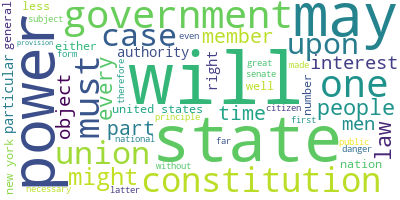

In [7]:
from wordcloud import WordCloud


# code adapted from https://towardsdatascience.com/end-to-end-topic-modeling-in-python-latent-dirichlet-allocation-lda-35ce4ed6b3e0

# Join the different processed titles together into one long text.
long_string = ','.join(list(dfPapers['text'].values))

# Create a WordCloud object
# You can change the parameters below
wordcloud = WordCloud(background_color="white", 
                        max_words=50, 
                        contour_width=3, 
                        contour_color='steelblue')

# Generate a word cloud
wordcloud.generate(long_string)

# Visualize the word cloud
wordcloud.to_image()


# Topic Modelling

## Latent Dirichlet Allocation (LDA)
A document is a collection of topics.
Topics are lists of words that appear frequently in those topics  
A recipe has:
* some words having to do with `food` (milk, eggs, a live badger)
* some having to do with `operations` (mix, heat, beat, burn)
* it will also include a bunch of other stuff (esp. on a food blog) - family, geography, calendar; perhaps gender, ethnicity.  

LDA uses a machine learning algorithm to calculate a pre-set number of topics and by looking at what words tend to go together tries to learn the underlying topics.  
The topic listings are not mutually exclusive; the same word can appear in more than one topic.

## How it works

> Still to do



## Topic Modeling Operations
We are running MALLET, a java program, through the python gensim library. This seems to give getter results than gensim's own lda algorithm.
We are then going to convert that model into gensim's own model so that we can use visualization tools.  
1. Import/update various Python libraries we will be using
2. Import MALLET and deploy it. 
3. Prepare our data for further processing
1. Create the "corpus" and the "dictionary" required  for analysis
2. Create an LDA model

## Import/update libraries

In [8]:
# much of the following repurposes:
# https://www.machinelearningplus.com/nlp/topic-modeling-gensim-python/

# Bunch o' modules we will be using
import numpy as np  # a library for arrays
from pprint import pprint # formats output ("pretty-prints")

# Gensim package for data text analysis
!pip install --upgrade gensim
import gensim
import gensim.corpora as corpora
from gensim.utils import simple_preprocess
from gensim.models import CoherenceModel

# Plotting tools
!pip install pyLDAvis
import pyLDAvis
import pyLDAvis.gensim  # don't skip this
import matplotlib.pyplot as plt
%matplotlib inline

# we are also going to want  remove "stopwords
import nltk
from nltk.corpus import stopwords
nltk.download('stopwords')
stop_words = set(stopwords.words('english'))

# run with the following un-commented to see what the stopwords are
# these are based on contemporary English; we'd need to do some linguistic work
# for the Federalist Papers

# print(len(stop_words))
# print(stop_words)


# # Enable logging for gensim - optional
# import logging
# logging.basicConfig(format='%(asctime)s : %(levelname)s : %(message)s', level=logging.ERROR)

     |████████████████████████████████| 24.2MB 169kB/s 
  Found existing installation: gensim 3.6.0
    Uninstalling gensim-3.6.0:
      Successfully uninstalled gensim-3.6.0
     |████████████████████████████████| 1.7MB 4.3MB/s 
  Created wheel for pyLDAvis: filename=pyLDAvis-3.2.2-py2.py3-none-any.whl size=135593 sha256=9b96b615d63c1274a72dc50019e5d03eaae7044d2cf5abbdea7845c8f63b46fd
  Stored in directory: /root/.cache/pip/wheels/74/df/b6/97234c8446a43be05c9a8687ee0db1f1b5ade5f27729187eae
Successfully built pyLDAvis


/usr/local/lib/python3.7/dist-packages/past/types/oldstr.py:5: DeprecationWarning: Using or importing the ABCs from 'collections' instead of from 'collections.abc' is deprecated since Python 3.3,and in 3.9 it will stop working
  from collections import Iterable
/usr/local/lib/python3.7/dist-packages/past/builtins/misc.py:4: DeprecationWarning: Using or importing the ABCs from 'collections' instead of from 'collections.abc' is deprecated since Python 3.3,and in 3.9 it will stop working
  from collections import Mapping
/usr/local/lib/python3.7/dist-packages/nltk/decorators.py:70: DeprecationWarning: `formatargspec` is deprecated since Python 3.5. Use `signature` and the `Signature` object directly
  formatvalue=lambda value: "")[1:-1]


[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


## Prepare our data for processing

In [9]:
# Get our data in the form of a list in which every FP document is 
# Represented as a list of words.

data = dfPapers['text'].values.tolist()
# uncommented below will print the text of the first text
# pprint(data[:1])

# tokenize
def paper_to_words(papers):
  """ Our first function! Yay!
      this function does the tokenization"""
  for paper in papers:
    yield(gensim.utils.simple_preprocess(str(paper), deacc=True))

#now remove stopwords
def remove_stopwords(texts):
  """ This function checks for and removes stopwords"""
  return [[word for word in simple_preprocess(str(doc)) if word not in stop_words] for doc in texts]

      
data_words = list(paper_to_words(data))

# To keep stopwords comment next uncomment following
data_to_use = data_words

# # To remove stopwords uncomment this line, comment preceding line
# data_words_no_stops = remove_stopwords(data_words)
# data_to_use = data_words_no_stops

# run with the following un-commented to see the first document
# print(data_to_use[:1])


## Prepare the "corpus" and "dictionary" required as input

In [10]:
# Create Dictionary
id2word = corpora.Dictionary(data_to_use)

# Create Corpus
texts = data_to_use

# Term Document Frequency: converts orderd string to "bag of words"
corpus = [id2word.doc2bow(text) for text in texts]

# # viewing data
# # uncomment and run to view
# corpus
# print(corpus[:1])

# # Human readable format of corpus (term-frequency)
# print(len(id2word))
# [[(id2word[id], freq) for id, freq in cp] for cp in corpus[:1]]


## Get, deploy MALLET; if necessary get Java.

In [11]:
# # un-comment if you need to update java
# def install_java():
#   !apt-get install -y openjdk-8-jdk-headless -qq > /dev/null      #install openjdk
#   os.environ["JAVA_HOME"] = "/usr/lib/jvm/java-8-openjdk-amd64"     #set environment variable
#   !java -version       #check java version
# install_java()

# getting Mallet
r = requests.get('http://mallet.cs.umass.edu/dist/mallet-2.0.8.zip')
z = zipfile.ZipFile(io.BytesIO(r.content))
z.extractall('/content') 

!chmod 764 /content/mallet-2.0.8/bin/mallet #gives owner (you) execute rights (7)

# just in case we need to set the environmental variables.
os.environ["JAVA_HOME"] = "/usr/lib/jvm/java-8-openjdk-amd64"
os.environ['MALLET_HOME'] = '/content/data/mallet-2.0.8/'
mallet_path = '/content/mallet-2.0.8/bin/mallet' 



## Build and view the LDA model in Mallet

`c_v` coherence score is a measure of how frequently words in a topic occur together.

In [17]:

from gensim.models.wrappers import LdaMallet

# can experiment with the number of topics, and the optimize interval
num_topics = 30        ## 20 is the default
optimize_interval = 40 ## allows mallet to make some topics more prominent than others
                       ## MALLET specs say "10 is reasonable"
                       ## reportedly 20-40 give good results
                       ## set to zero to turn off

ldamallet = gensim.models.wrappers.LdaMallet(mallet_path, 
                                             corpus=corpus, 
                                             num_topics=num_topics, 
                                             optimize_interval=optimize_interval,
                                             id2word=id2word)

# Show Topics and coherence score
pprint(ldamallet.show_topics(formatted=True, num_topics=num_topics))
# to do: prettier output of model
# write now showing top ten models

coherence_model_ldamallet = CoherenceModel(model=ldamallet, 
                                           texts=data_to_use, 
                                           dictionary=id2word, coherence='c_v')
coherence_ldamallet = coherence_model_ldamallet.get_coherence()
print('\nCoherence Score: ', coherence_ldamallet)

[(0,
  '0.033*"revenue" + 0.031*"taxation" + 0.024*"duties" + 0.019*"taxes" + '
  '0.016*"objects" + 0.013*"land" + 0.012*"resources" + 0.009*"community" + '
  '0.009*"treasury" + 0.008*"expenses"'),
 (1,
  '0.053*"government" + 0.026*"constitution" + 0.024*"states" + 0.023*"state" '
  '+ 0.020*"authority" + 0.019*"national" + 0.016*"people" + 0.014*"federal" + '
  '0.013*"laws" + 0.013*"union"'),
 (2,
  '0.048*"rights" + 0.023*"liberty" + 0.021*"bill" + 0.017*"constitution" + '
  '0.015*"press" + 0.014*"representatives" + 0.014*"expense" + '
  '0.013*"congress" + 0.010*"provisions" + 0.010*"legislatures"'),
 (3,
  '0.032*"government" + 0.029*"union" + 0.022*"power" + 0.020*"national" + '
  '0.013*"people" + 0.012*"kind" + 0.010*"system" + 0.010*"country" + '
  '0.009*"governments" + 0.009*"general"'),
 (4,
  '0.080*"people" + 0.035*"governments" + 0.026*"government" + '
  '0.015*"measures" + 0.012*"side" + 0.011*"important" + 0.010*"connected" + '
  '0.009*"whilst" + 0.008*"objects" +

## Let's do some basic examination

The next block builds a table that gives the document mostly closely associated with a topic

In [18]:

%load_ext google.colab.data_table

def format_topics_sentences(ldamodel=ldamallet, corpus=corpus, texts=data_to_use):
    # Init output
    paper_topics_df = pd.DataFrame()

    # Get main topic in each document
    for i, row in enumerate(ldamodel[corpus]):
        row = sorted(row, key=lambda x: (x[1]), reverse=True)
        # Get the Dominant topic, Perc Contribution and Keywords for each document
        for j, (topic_num, prop_topic) in enumerate(row):
            if j == 0:  # => dominant topic
                wp = ldamodel.show_topic(topic_num)
                topic_keywords = ", ".join([word for word, prop in wp])
                paper_topics_df = paper_topics_df.append(pd.Series([int(topic_num), round(prop_topic,4), topic_keywords]), ignore_index=True)
            else:
                break
    paper_topics_df.columns = ['Dominant_Topic', 'Perc_Contribution', 'Topic_Keywords']

    # to align MALLET topic indexing [1-based]  with gensim/Python [0-based]
    paper_topics_df['Dominant_Topic'] = paper_topics_df['Dominant_Topic'] + 1

    # Add original text to the end of the output
    # contents = pd.Series(texts)
    # paper_topics_df = pd.concat([paper_topics_df, contents], axis=1)
    return(paper_topics_df)


df_topic_pages_keywords = format_topics_sentences(ldamodel=ldamallet, corpus=corpus, texts=data_to_use)

# Format
df_dominant_topic = df_topic_pages_keywords.reset_index()

df_dominant_topic.columns = ['Document_No', 'Dominant_Topic', 'Topic_Perc_Contrib', 'Keywords']

# increase document number to align with original chapter nos.
df_dominant_topic["Document_No"] = df_dominant_topic["Document_No"] + 1
df_dominant_topic["file_name"] = dfPapers["file_name"]

# reorder ## better way of doing this?
column_names = ['Document_No','file_name', 'Dominant_Topic', 'Topic_Perc_Contrib', 'Keywords']
df_dominant_topic = df_dominant_topic.reindex(columns=column_names)

# Show
df_dominant_topic

The google.colab.data_table extension is already loaded. To reload it, use:
  %reload_ext google.colab.data_table


,Document_No,file_name,Dominant_Topic,Topic_Perc_Contrib,Keywords
0,1,federalist_1,10.0,0.2184,"power, legislature, provision, constitution, p..."
1,2,federalist_2,15.0,0.2467,"nations, war, foreign, peace, america, confede..."
2,3,federalist_3,15.0,0.3173,"nations, war, foreign, peace, america, confede..."
3,4,federalist_4,15.0,0.3142,"nations, war, foreign, peace, america, confede..."
4,5,federalist_5,15.0,0.5824,"nations, war, foreign, peace, america, confede..."
...,...,...,...,...,...
80,81,federalist_81,16.0,0.3342,"courts, court, jurisdiction, law, cases, supre..."
81,82,federalist_82,16.0,0.4228,"courts, court, jurisdiction, law, cases, supre..."
82,83,federalist_83,24.0,0.3485,"jury, trial, cases, civil, mode, common, crimi..."
83,84,federalist_84,3.0,0.3241,"rights, liberty, bill, constitution, press, re..."


## Reformat and view in pyLDAvis

Repackage our MALLET model as a gensim model so we can use the `pyLDAvis` tools.  

**Red** Frequency in particular topic ["lift"]  
**Blue** Frequency in the model overall ["frequency"]  

**Lambda metric:** proportion of frequency in overall model to frequency in topic.  
> "the “the ratio of a term’s probability within a topic to its marginal probability across the corpus,” or the ratio between its red bar and blue bar"  
[https://we1s.ucsb.edu/research/we1s-tools-and-software/topic-model-observatory/tmo-guide/tmo-guide-pyldavis/]   

When **`lambda`** is set to 1 (default) words are sorted by their frequency in the topic (the "lift"). When set to 0 words whose frequency in the topic is similar to to their frequency overall appear at the top.   
[Note: Issues with nterpretability, display?]


In [22]:
# makes use of https://medium.com/@jobethmuncy/formatting-pyldavis-and-mallet-model-7c0d00061b67

# convert to gensim LDA model
mallet_lda_model = gensim.models.wrappers.ldamallet.malletmodel2ldamodel(ldamallet)

pyLDAvis.enable_notebook()
vis = pyLDAvis.gensim.prepare(mallet_lda_model, corpus, id2word,sort_topics = False)
pyLDAvis.display(vis)


/usr/local/lib/python3.7/dist-packages/pyLDAvis/_prepare.py:236: RuntimeWarning: divide by zero encountered in log
  log_1 = np.log(pd.eval("(topic_given_term.T / topic_proportion)"))
/usr/local/lib/python3.7/dist-packages/pyLDAvis/_prepare.py:259: RuntimeWarning: divide by zero encountered in log
  log_lift = np.log(pd.eval("topic_term_dists / term_proportion")).astype("float64")
/usr/local/lib/python3.7/dist-packages/pyLDAvis/_prepare.py:260: RuntimeWarning: divide by zero encountered in log
  log_ttd = np.log(topic_term_dists).astype("float64")


In [23]:
print(vis.topic_order)

[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30]


# Stylometry and Author Identification
> Adapted from "Programming Historian"   
https://doi.org/10.46430/phen0078

If you have not started at "getting the text" go back to the first section above.   
Running those code blocks will return a text in all lower case with punctuation removed.

## First let's modify the dataframe we created to add attribution
Follows the canonical division plus test case as in PH

In [ ]:
import nltk

%unload_ext google.colab.data_table
# the "canonical" division into authors plus one test case, as in PH
papers = {
    'Madison': [10, 14, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48],
    'Hamilton': [1, 6, 7, 8, 9, 11, 12, 13, 15, 16, 17, 21, 22, 23, 24,
                 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 59, 60,
                 61, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77,
                 78, 79, 80, 81, 82, 83, 84, 85],
    'Jay': [2, 3, 4, 5],
    'Shared': [18, 19, 20],
    'Disputed': [49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 62, 63],
    'TestCase': [64]
}
k, v = list(papers.keys()), list(papers.values())
def return_attrib (num):
  """ checks for the document no in lists of values
      returns first letter of attribution. """
  for i in v:
    if num in i: 
      return k[v.index(i)][0]

# insert attribution to datatable in first position if it does not exist
if not "attrib" in dfPapers.columns:
  dfPapers.insert(loc=0, column='attrib',value='')




dfPapers["attrib"] = dfPapers["num"].apply(return_attrib)
dfPapers.head(5)    


## Feature Selection
We are choosing 30 as in PH example.

Create a composite feature set for all texts (except test case)

In [ ]:
# filter dataframe to exclude testcase
# this is a variation of the operation we used above for the word cloud
# create a single string
corpus = ' '.join(dfPapers["text"][dfPapers["attrib"] != "T"].values)

#separate into a list of values
corpus_tokens = corpus.split()

# create frequency list using built in nltk function
whole_corpus_freq_dist = list(nltk.FreqDist(corpus_tokens).most_common(30))

# # uncomment to see the check the first 10
# whole_corpus_freq_dist[ :10 ]

# data structure to contain our statistical information
dfFeatures = pd.DataFrame( columns=["feats"])
dfFeatures["feats"] = [w for w, freq in whole_corpus_freq_dist]
dfFeatures["corpus"] = [freq for w, freq in whole_corpus_freq_dist]

# calculate frequency for each of the "authors"
# authors to test
authors = ("H","M","J","S","D","T")
for author in authors:
  author_corpus = ' '.join(dfPapers["text"][dfPapers["attrib"] == author].values)

  #separate into a list of values
  author_tokens = author_corpus.split()

  # create frequency list using built in nltk function
  author_length = len(author_tokens)

  # copy the features to a list
  # for each feature count the proportion of features to total author words
  # append to df

  features = dfFeatures.feats.to_list()
  author_features = [author_tokens.count(x)/author_length for x in features]
  # dfFeatures[author] = author_features
  dfFeatures[author] = author_features

dfFeatures.head(5)



## Means, Standard Deviation, z-scores

In [ ]:
import math
# mean of the mean frequency of each feature
# exclude testcase from means
authors_no_T = ["H","M", "J", "S", "D"]

#calculate the means of columns
dfFeatures["means"] = dfFeatures[authors_no_T].mean(axis=1)

# dfFeatures

# calculate stdev of columns as for sample
# formula stdev = sum(sqrt((x[i] - x[sample])^2/(n - 1)))
# should be a more efficient way of doing this in Pandas but
# (a) I am a newbie
# (b) this makes the process explicit

n = len(authors_no_T)
stdev = list([0]*len(features))

for i in range(len(features)):
  squ_diff_fr_mean = 0
  sum_squ_diff = 0
  author_feature_values = dfFeatures.iloc[[i],[2,3,4,5,6]].values[0]
  feature_mean = dfFeatures.iloc[[i],[8]].values[0]
  
  for j in range(len(authors_no_T)):
    squ_diff_fr_mean = (author_feature_values[j] - feature_mean[0])**2
    sum_squ_diff = sum_squ_diff + squ_diff_fr_mean
    stdev[i] = math.sqrt(sum_squ_diff/(n - 1))

dfFeatures["stdev"] = stdev

# z-scores
# formula z[j] = (Observed[j] - mean[j])/stdev[j]

# dataframe to hold z scores
z_cols = list(authors)
z_cols.extend(["means", "stdev"])
#z_cols
#calcuate z-scores
dfZ = dfFeatures[z_cols].copy()
for author in authors:
  dfZ[author] = (dfZ[author] - dfZ["means"])/dfZ["stdev"]
dfZ.head(7)


Sample values in PH for T (Federalist 64) are:
```
Test case z-score for feature the is -0.7692828380408238
Test case z-score for feature of is -1.8167784558461264
Test case z-score for feature to is 1.032705844508835
Test case z-score for feature and is 1.0268752924746058
Test case z-score for feature in is 0.6085448501260903
Test case z-score for feature a is -0.9341289591084886
Test case z-score for feature be is 1.0279650702511498
```
Our values are close to those calculated there.

## Calculate Burrows's Delta  
> (from PH)  
Finally, calculate a delta score comparing the anonymous paper with each candidate’s subcorpus. To do this, take the average of the ***absolute values of the differences between the z-scores for each feature between the anonymous paper and the candidate’s subcorpus.*** (Read that twice!) This gives equal weight to each feature, no matter how often the words occur in the texts; otherwise, the top 3 or 4 features would overwhelm everything else. Figure 8 shows the equation for `Delta`, where `Z(c,i)` is the z-score for feature ‘i’ in candidate ‘c’, and `Z(t,i)` is the z-score for feature ‘i’ in the test case.


In [ ]:
# formula Delta = sum(abs())

# new data frame for delta
dfDelta = dfZ.copy()
col_keys = list(authors_no_T)
col_vals = list(authors_no_T)
for idx, v in enumerate(col_vals):
  col_vals[idx] = "T_to_" + col_vals[idx]
col_labels = dict(zip(col_keys, col_vals))
dfDelta = dfDelta.rename(index=str, columns=col_labels)

for v in col_vals:
  dfDelta[v] = abs(dfDelta[v] - dfDelta["T"])

# add a row for sums and and delta and calculate

# 
dfDelta.loc["sum"] = dfDelta.sum(axis=0)
dfDelta.loc["delta"] = dfDelta.loc["sum"]/len(features)

# clean up stupid error
all_col_labels = list(dfDelta.columns)
for col in all_col_labels:
  if col not in col_vals:
    dfDelta.loc["sum",col] = ""
    dfDelta.loc["delta", col] = ""

dfDelta.tail(2)

In [ ]:
# report out

for col in col_vals:
  print("Delta for " + col + " is: ",dfDelta.loc["delta",col])


This was the conclusion/outpt in PH
```
Delta score for candidate Hamilton is 1.768470453004334
Delta score for candidate Madison is 1.6089724119682816
Delta score for candidate Jay is 1.5345768956569326
Delta score for candidate Disputed is 1.5371768107570636
Delta score for candidate Shared is 1.846113566619675
```
Our calculations are similar but do not match precisely. Why? Error in calculating delta? Slightly different text pre-processing?
